In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('XGBmodel.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('XGBvectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('XGBlabel_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('LSTMmodel.h5')

with open('LSTMtokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(stacked_features, y_test)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test, final_predictions_rf)
report_rf = classification_report(y_test, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, final_predictions_rf))


581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step
Random Forest Meta-Learner Accuracy: 99.19%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.99      0.98      0.99      1999
     bipolar       0.98      0.97      0.98      1941
  depression       0.98      0.99      0.98      1959
      normal       1.00      1.00      1.00     10679
        ptsd       0.99      0.99      0.99      1987

    accuracy                           0.99     18565
   macro avg       0.99      0.99      0.99     18565
weighted avg       0.99      0.99      0.99     18565

Confusion Matrix (Random Forest):
 [[ 1969     8    14     3     5]
 [    4  1886    15    30     6]
 [    7     6  1937     0     9]
 [    0    15     1 10663     0]
 [    5     9    11     2  1960]]


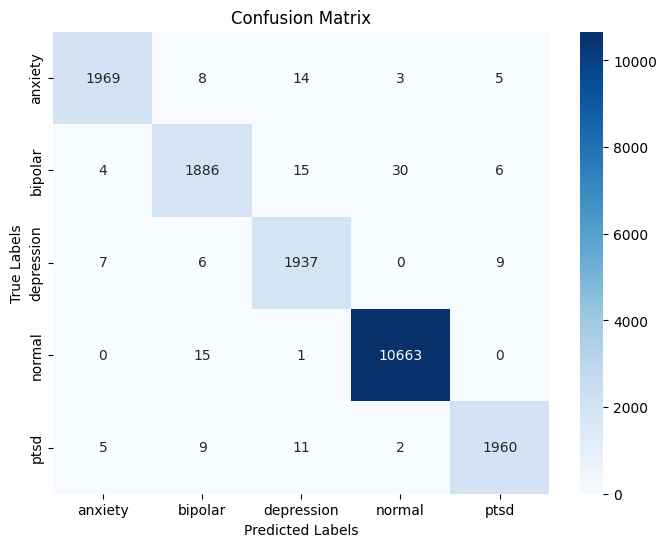

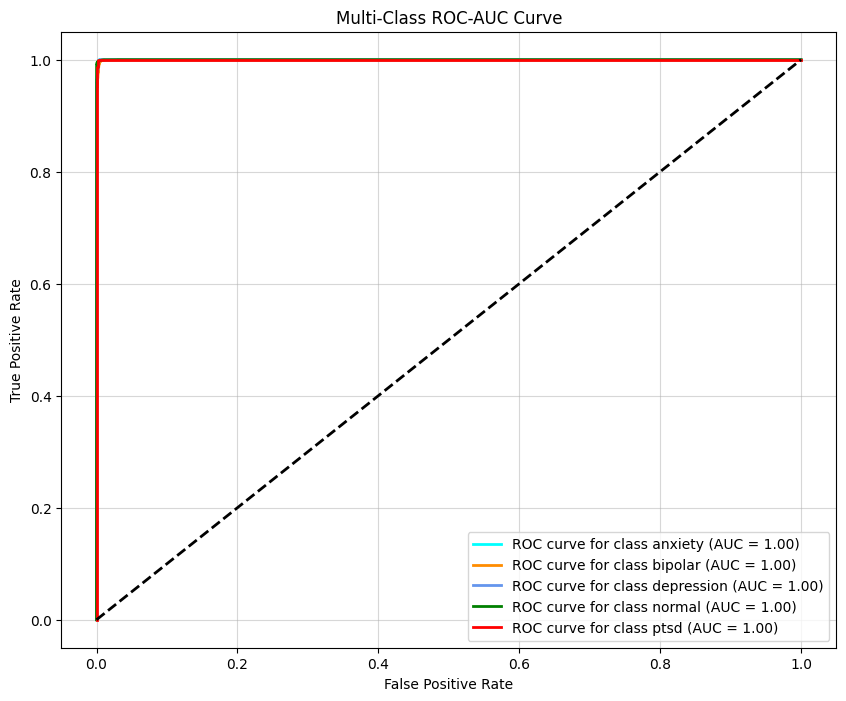

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class ROC-AUC
y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
final_predictions_proba = meta_learner_rf.predict_proba(stacked_features)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], final_predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC-AUC curve
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.title('Multi-Class ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()


In [ ]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X_test = data['cleaned_text']
y_test = data['mental_health_issue']
y_test = label_encoder.transform(y_test)

# Preprocess the text
X_test_lr = lr_vectorizer.transform(X_test)
X_test_svm = svm_vectorizer.transform(X_test)
X_test_nb = nb_vectorizer.transform(X_test)
X_test_xgb = tfidf_vectorizer.transform(X_test)
X_test_lstm = lstm_tokenizer.texts_to_sequences(X_test)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_test_lr)
svm_predictions_proba = svm_model.predict_proba(X_test_svm)
nb_predictions_proba = nb_model.predict_proba(X_test_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_test_xgb)
lstm_predictions_proba = lstm_model.predict(X_test_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    n_estimators=3000,         # Number of trees
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node

    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,            # Whether to use bootstrapping

    random_state=42            # For reproducibility
    )
meta_learner_rf.fit(stacked_features, y_test)

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Predict using the Random Forest meta-learner
final_predictions_rf = meta_learner_rf.predict(stacked_features)

# Evaluate the Random Forest ensemble model
accuracy_rf = accuracy_score(y_test, final_predictions_rf)
report_rf = classification_report(y_test, final_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Accuracy: {accuracy_rf * 100:.2f}%")
print("Classification Report (Random Forest):\n", report_rf)
print("Confusion Matrix (Random Forest):\n", confusion_matrix(y_test, final_predictions_rf))


581/581 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step
Random Forest Meta-Learner Accuracy: 99.16%
Classification Report (Random Forest):
               precision    recall  f1-score   support

     anxiety       0.99      0.98      0.99      1999
     bipolar       0.98      0.97      0.98      1941
  depression       0.98      0.99      0.98      1959
      normal       1.00      1.00      1.00     10679
        ptsd       0.99      0.99      0.99      1987

    accuracy                           0.99     18565
   macro avg       0.99      0.99      0.99     18565
weighted avg       0.99      0.99      0.99     18565

Confusion Matrix (Random Forest):
 [[ 1969     8    15     3     4]
 [    4  1885    16    29     7]
 [    8     8  1933     1     9]
 [    1    16     1 10661     0]
 [    5     8    11     2  1961]]


## Final After Cross Validation Check

In [2]:
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Load models and vectorizers
with open('LRmodel.pkl', 'rb') as file:
    lr_model = pickle.load(file)

with open('LRvectorizer.pkl', 'rb') as file:
    lr_vectorizer = pickle.load(file)

with open('SVMmodel.pkl', 'rb') as file:
    svm_model = pickle.load(file)

with open('SVMvectorizer.pkl', 'rb') as file:
    svm_vectorizer = pickle.load(file)

with open('xgb_model.pkl', 'rb') as file:
    xgb_model = pickle.load(file)

with open('tfidf_vectorizer.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import pad_sequences

lstm_model = load_model('lstm_model.h5')

with open('LSTM_tokenizer.pkl', 'rb') as file:
    lstm_tokenizer = pickle.load(file)

with open('NBmodel.pkl', 'rb') as file:
    nb_model = pickle.load(file)

with open('NBvectorizer.pkl', 'rb') as file:
    nb_vectorizer = pickle.load(file)

# Load the test dataset
data = pd.read_csv('preprocessed_mental_health.csv')
data.dropna(subset=['cleaned_text'], inplace=True)

X = data['cleaned_text']
y = data['mental_health_issue']
y = label_encoder.transform(y)

# Preprocess the text
X_lr = lr_vectorizer.transform(X)
X_svm = svm_vectorizer.transform(X)
X_nb = nb_vectorizer.transform(X)
X_xgb = tfidf_vectorizer.transform(X)
X_lstm = lstm_tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=100, padding='post', truncating='post')

# Get individual model probabilities
lr_predictions_proba = lr_model.predict_proba(X_lr)
svm_predictions_proba = svm_model.predict_proba(X_svm)
nb_predictions_proba = nb_model.predict_proba(X_nb)
xgb_predictions_proba = xgb_model.predict_proba(X_xgb)
lstm_predictions_proba = lstm_model.predict(X_lstm)

# Stack the predictions to create the feature matrix for the meta-learner
stacked_features = np.hstack((
    lr_predictions_proba,
    svm_predictions_proba,
    nb_predictions_proba,
    xgb_predictions_proba,
    lstm_predictions_proba
))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    stacked_features, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest as the meta-learner
meta_learner_rf = RandomForestClassifier(
    max_depth=None,            # Maximum depth of each tree
    min_samples_split=20,      # Minimum number of samples to split a node
    min_samples_leaf=1,        # Minimum number of samples in a leaf node
    max_features='sqrt',       # Number of features to consider at each split
    bootstrap=False,           # Whether to use bootstrapping
    random_state=42            # For reproducibility
)

# Fit the model on training data
meta_learner_rf.fit(X_train, y_train)

# Predict on the test set
test_predictions_rf = meta_learner_rf.predict(X_test)

# Evaluate the Random Forest ensemble model
test_accuracy_rf = accuracy_score(y_test, test_predictions_rf)
report_rf = classification_report(y_test, test_predictions_rf, target_names=label_encoder.classes_)

print(f"Random Forest Meta-Learner Test Accuracy: {test_accuracy_rf * 100:.2f}%")
print("Classification Report (Test Set):\n", report_rf)
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, test_predictions_rf))

# Save the trained Random Forest meta-learner
with open('meta_learner_rf.pkl', 'wb') as file:
    pickle.dump(meta_learner_rf, file)

# Calculate the mean and standard deviation of validation accuracies
cross_val_accuracies = cross_val_score(
    meta_learner_rf, stacked_features, y, cv=5, scoring='accuracy'
)

mean_val_accuracy = np.mean(cross_val_accuracies)
std_val_accuracy = np.std(cross_val_accuracies)

# Print cross-validation results
print(f"Cross-Validation Accuracies: {cross_val_accuracies}")
print(f"Mean Validation Accuracy: {mean_val_accuracy * 100:.2f}%")
print(f"Validation Accuracy Std Dev: {std_val_accuracy * 100:.2f}%")

581/581 ━━━━━━━━━━━━━━━━━━━━ 48s 81ms/step
Random Forest Meta-Learner Test Accuracy: 97.66%
Classification Report (Test Set):
               precision    recall  f1-score   support

     anxiety       0.98      0.97      0.97       400
     bipolar       0.95      0.91      0.93       388
  depression       0.96      0.96      0.96       392
      normal       0.99      0.99      0.99      2136
        ptsd       0.97      0.97      0.97       397

    accuracy                           0.98      3713
   macro avg       0.97      0.96      0.96      3713
weighted avg       0.98      0.98      0.98      3713

Confusion Matrix (Test Set):
 [[ 389    1    4    3    3]
 [   1  353    5   24    5]
 [   6    6  375    1    4]
 [   0   11    0 2124    1]
 [   2    2    6    2  385]]
Cross-Validation Accuracies: [0.97683814 0.96902774 0.98033935 0.96552653 0.9730676 ]
Mean Validation Accuracy: 97.30%
Validation Accuracy Std Dev: 0.53%


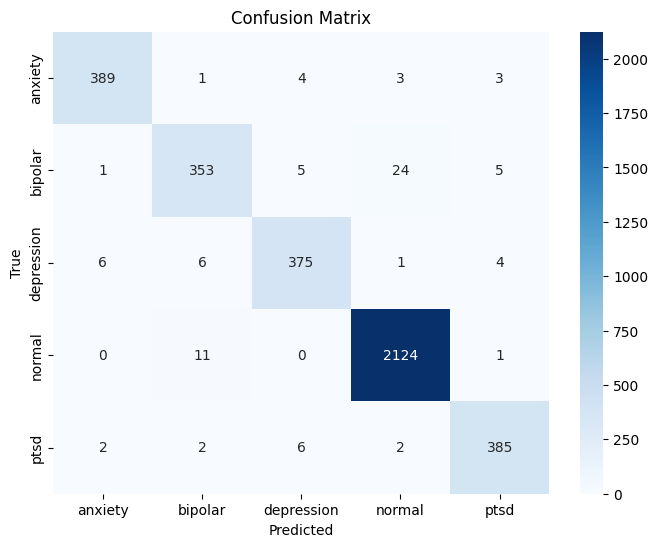

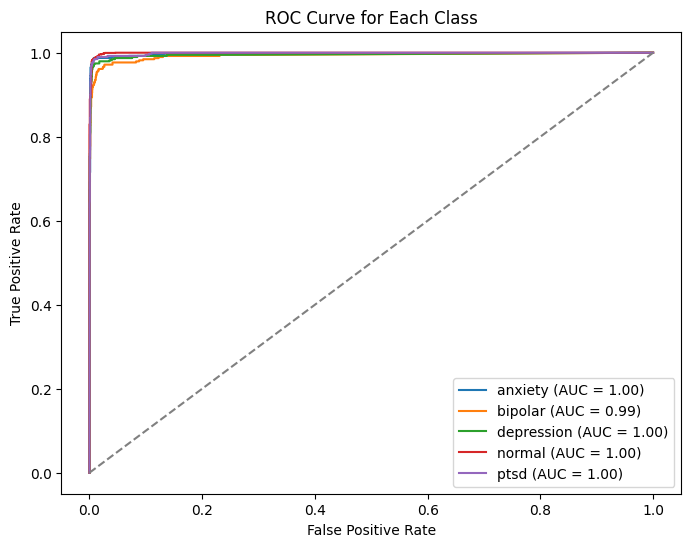

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Evaluate the Random Forest ensemble model
test_accuracy_rf = accuracy_score(y_test, test_predictions_rf)
report_rf = classification_report(y_test, test_predictions_rf, target_names=label_encoder.classes_)


# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC AUC Curve
# Calculate the probability scores for the test set
y_pred_proba_rf = meta_learner_rf.predict_proba(X_test)

# Create ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_proba_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()
